# 2020 Election Swing District Analysis

After Democrats underperformed expectations in the House of Representatives in the 2020 election, moderates in the party immediately [accused progressives of pulling the party too far to the left and costing moderates in swing districts](https://www.sfgate.com/politics/article/Nancy-Pelosi-Abigail-Spanberger-call-defund-police-15707741.php). Alexandria Ocasio-Cortez shot back by noting that [progressives outperformed expectations, even in swing districts](https://www.nytimes.com/2020/11/07/us/politics/aoc-biden-progressives.html) (and that [many moderates underinvested in digital campaigning](https://twitter.com/AOC/status/1324698828944138243)).

In this notebook, I'll try to understand the relationship between a candidate's ideology and how well that candidate does electorally. I'm also going to investigate the candidates in a handful of districts where this relationship looks particularly interesting.

This is version 1.0 of this notebook. You can always find the latest version (as well as the data used) in [this github repository](https://github.com/rameshvs/election2020-analysis).

### Some disclaimers

* This analysis only looks at electoral & candidate ideological data, and not at other quantitative factors like how much Democrats spent on TV vs digital media.
* This analysis does **not** try to address the question of whether progressive activism led to a backlash that caused moderate or conservative Democrats to lose. Instead, it only examines each candidate's ideology and comparing that to their electoral record.
  * There's plenty of quantitative academic work about the effect of [protests on racial resentment](https://osf.io/preprints/socarxiv/ap46d/).
* Quantifying ideology is hard, and the data I'm using [has limitations](https://www.govtrack.us/about/analysis#ideology).
* I'm not claiming an unbiased analysis: it's likely that my personal politics will leak in to what I find. Instead, I'm providing everything here for you to draw your own conclusions (or, for those inclined, to conduct further analysis).
* I'm not claiming that this analysis is original, or even that I'm looking at the correct variables. My expertise is in data science, not in political science. If you have any feedback, feel free to let me know on Twitter!

If you want to run the code here yourself, you'll need to download the data yourself from each source individually or from [this prepackaged link](). TODO

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
pd.set_option('precision', 2)

In [2]:
def percent_to_num(col: pd.Series) -> pd.Series:
    """Converts a column with strings like '20.3%' to floats like 0.203"""
    return col.str.strip('%').astype('float')/100

## Loading and preprocess the data

### 2020 House Election

Data about the 2020 House election was taken from [this Washington post report](https://www.washingtonpost.com/elections/election-results/house-2020/) on the evening of November 9, 2020. 

In [3]:
election2020 = pd.read_csv('wapo-house2020-20201109.csv')
election2020.head()

,District,2020 Dem,2020 Rep,RPT,Incumbent party,Safety
0,AZ-1,51.70%,48.30%,>99%,D,Vulnerable
1,CA-21,48.20%,51.80%,83%,D,Vulnerable
2,CA-48,49.10%,50.90%,>99%,D,Vulnerable
3,FL-26,48.30%,51.70%,95%,D,Vulnerable
4,IA-1,48.70%,51.30%,90%,D,Vulnerable


In [4]:
def compute_winner(dem_margin: float) -> str:
    """Returns 'Dem' or 'Rep' depending on the margin in a district"""
    if dem_margin == 0:
        return 'Tie'
    elif dem_margin < 0:
        return 'Rep'
    elif dem_margin > 0:
        return 'Dem'
    
# Round up: more than 99% reporting is close enough to 100%
election2020.loc[election2020['RPT'] == '>99%', 'RPT'] = '100%'

for column in ['2020 Dem', '2020 Rep', 'RPT']:
    # If a party didn't run a candidate, count their vote share as 0
    # (this applies to the RPT column in FL-25 as well: not sure why)
    election2020.loc[election2020[column] == '-', column] = '0%'
    
    # Count unchallenged races as 100% for the incumbent
    election2020.loc[election2020[column] == 'Unc.', column] = '100%'

    # Convert string '30%' to float 0.3
    election2020[column] = percent_to_num(election2020[column])
    
election2020['HouseDem20 margin'] = election2020['2020 Dem'] - election2020['2020 Rep']
election2020['House20 winner'] = election2020['HouseDem20 margin'].apply(compute_winner)

# For readability, we'll drop the vote percents for Dem/Rep, and just keep the margin
election2020 = election2020.drop(['2020 Dem', '2020 Rep'], axis=1)

In [5]:
election2020.head()

,District,RPT,Incumbent party,Safety,HouseDem20 margin,House20 winner
0,AZ-1,1.00,D,Vulnerable,0.03,Dem
1,CA-21,0.83,D,Vulnerable,-0.04,Rep
2,CA-48,1.00,D,Vulnerable,-0.02,Rep
3,FL-26,0.95,D,Vulnerable,-0.03,Rep
4,IA-1,0.90,D,Vulnerable,-0.03,Rep


### Data from 2010-2018 House elections


Data from House elections for 2018 and earlier comes from the [MIT Election Lab](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IG0UN2).

In [6]:
house = pd.read_csv('election-lab-1976-2018-house2.csv', encoding = "ISO-8859-1")
house.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
0,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Bill Davenport,democrat,False,total,58906,157170,False,20200424
1,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Jack Edwards,republican,False,total,98257,157170,False,20200424
2,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,NaN,NaN,True,total,7,157170,False,20200424
3,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,J. Carole Keahey,democrat,False,total,66288,156362,False,20200424
4,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,NaN,NaN,True,total,5,156362,False,20200424


In [7]:
def electionlab_district(row: pd.Series) -> str:
    """
    Compute representation like 'CA-13' or 'MT-AL' 
    from a row of the above table
    """
    # 0 -> "AL" for at-large
    district = row['district'] or 'AL'
    
    state = row['state_po']
    return f'{state}-{district}'

def get_party_and_year(row: pd.Series) -> str:
    """Computes a string like 'Dem 2018' or 'Rep 2014' from a row"""
    # In MN and ND, the Dem party has a slightly
    # different name due to merging with other parties
    raw_party = str(row['party'])
    if raw_party.startswith('democrat'):
        party = 'Dem'
    elif raw_party == 'republican':
        party = 'Rep'
    else:
        # We'll remove third parties from this analysis
        return np.nan
    
    year = row['year']
    return f'{party} {year}'

years = range(2012, 2020, 2)
parties = ('Dem', 'Rep')

# Keep general elections from 2012 onward only
house = house[
    (house['stage'] == 'gen') 
    & (house['runoff'] != True)  # include missing vals
    & (~house['special'])
    & (house['year'].isin(years))
].copy()

house['vote_proportion'] = house['candidatevotes'] / house['totalvotes']

house['District'] = house.apply(electionlab_district, axis=1)
house['party_year'] = house.apply(get_party_and_year, axis=1)
house = house[pd.notnull(house['party_year'])]

house = house.loc[:, ['District', 'party_year', 'vote_proportion']]

# If a party ran multiple candidates in a district, choose the one
# with the highest vote share
house = house.groupby(['District', 'party_year']).max()

# Pivot the `party_year` column into 'Dem 2018', 'Rep 2018', etc
house = house.loc[:, 'vote_proportion'].unstack(level=-1).reset_index()
del house.index.name

for year in years:
    for party in parties:
        column = f'{party} {year}'
        house.loc[pd.isna(house[column]), column] = 0
    house[f'HouseDem{year-2000} margin'] = house[f'Dem {year}'] - house[f'Rep {year}']

margin_columns = [f'HouseDem{y-2000} margin' for y in years]
house['HouseDemAvg margin'] = house.loc[:, [f'HouseDem{y-2000} margin' for y in years]].mean(axis=1)
margin_columns.append('HouseDemAvg margin')

# To make the table easier to read, we'll only keep the margins from 2018 and the 2012-2018 average.
house = house.loc[:, ['District'] + margin_columns[-2:]]

house.head()

party_year,District,HouseDem18 margin,HouseDemAvg margin
0,AK-AL,-0.07,-0.17
1,AL-1,-0.26,-0.64
2,AL-2,-0.23,-0.23
3,AL-3,-0.27,-0.31
4,AL-4,-0.60,-0.76


### Data from 2016, 2012, and 2008 presidential elections

Data about the 2016, 2012, and 2008 presidential elections was taken from [Daily Kos](https://www.dailykos.com/stories/2018/2/21/1742660/-The-ultimate-Daily-Kos-Elections-guide-to-all-of-our-data-sets) ([direct spreadsheet link](https://docs.google.com/spreadsheets/d/1VfkHtzBTP5gf4jAu8tcVQgsBJ1IDvXEHjuMqYlOgYbA/edit#gid=0)). To the best of my knowledge, they're the only source that provides presidential race results, grouped by district, for free. (I manually adjusted the header row after downloading.)

In [8]:
prez = pd.read_csv('pres_by_district.csv').iloc[:, :9]
prez.head()

,District,Incumbent,Party,Clinton 2016,Trump 2016,Obama 2012,Romney 2012,Obama 2008,McCain 2008
0,AK-AL,"Young, Don",(R),37.6,52.8,41.2,55.3,38.1,59.7
1,AL-01,"Byrne, Bradley",(R),34.1,63.5,37.4,61.8,38.5,60.9
2,AL-02,"Roby, Martha",(R),33.0,64.9,36.4,62.9,35.0,64.5
3,AL-03,"Rogers, Mike",(R),32.3,65.3,36.8,62.3,36.6,62.6
4,AL-04,"Aderholt, Rob",(R),17.4,80.4,24.0,74.8,25.5,73.3


In [9]:
def unpad_district(district: str) -> str:
    """Converts 'AL-01' to 'AL-1', etc. for consistency"""
    return district.replace('-0', '-')

In [10]:
margin16 = (prez['Trump 2016'] - prez['Clinton 2016'])/100
margin12 = (prez['Obama 2012'] - prez['Romney 2012'])/100

prez = pd.DataFrame({
    'District': prez['District'].apply(unpad_district),
    'Trump16 margin': margin16,
    'Obama12 margin': margin12,
})
prez.head()

,District,Trump16 margin,Obama12 margin
0,AK-AL,0.15,-0.14
1,AL-1,0.29,-0.24
2,AL-2,0.32,-0.27
3,AL-3,0.33,-0.26
4,AL-4,0.63,-0.51


### Ideology

Data about representatives' ideology is available for download [from govtrack](https://www.govtrack.us/congress/members/report-cards/2019/house/ideology). The `ideology` column represents the ideology of the district's representative for 2019 only, with 0 being the most liberal and 1 being the most conservative. 

For reference, here are scores for a handful of well-known Representatives:
* Rep. Matt Gaetz (R, FL-1), a prominent Trump ally, has a score of `ideology = 0.9`.
* Rep. Steve King (R, IA-4), a white supremacist who's been disavowed by his own party, has a score of `ideology = 0.77`.
* Rep. Abigail Spanberger (D, VA-7), who led the complaints about Democrats moving too far to the left, has a score of `ideology = 0.48`.
* Rep. Justin Amash (L, MI-3), who left the Republican party and was the only non-Democrat to vote in favor of impeaching Donald Trump, has a score of `ideology = 0.4`.
* Speaker Nancy Pelosi (D, CA-12) has a score of `ideology = 0.34`.
* Rep. Alexandria Ocasio-Cortez (D, NY-14) has a score of `ideology = 0.09`.

Govtrack's scores are computed based only on sponsoring and co-sponsoring of bills. You can read about how they're computed and what their limitations are on [their methodology page](https://www.govtrack.us/about/analysis#ideology). For example, co-sponsoring legislation like the Green New Deal and Medicare for All would lead to a score closer to 0.

In [11]:
ideology = pd.read_csv('govtrack-stats-2019-house-ideology.csv')
ideology.head()

,rank_from_low,rank_from_high,percentile,ideology,id,bioguide_id,state,district,name
0,1,437,0,0.00,400237,L000551,CA,13,b'Lee'
1,2,436,0,0.03,400360,S001145,IL,9,b'Schakowsky'
2,3,435,0,0.03,400295,N000147,DC,0,b'Norton'
3,4,434,1,0.06,412644,W000822,NJ,12,b'Watson Coleman'
4,5,433,1,0.06,412782,P000617,MA,7,b'Pressley'


In [12]:
def ideology_district(row: pd.Series) -> str:
    """
    Compute representation like 'CA-13' or 'MT-AL' 
    from a row of the above table
    """
    # 0 -> "AL" for at-large
    district = row.district or 'AL'
    return f'{row.state}-{district}'

ideology = pd.DataFrame({
    'District': ideology.apply(ideology_district, axis=1),
    'Govtrack ideology': ideology['ideology'],
    'last_name': ideology['name'],
})

### Join all data sources

In [13]:
datasets = [prez, house, election2020, ideology]
data = datasets[0]
for to_merge in datasets[1:]:
    data = pd.merge(data, to_merge, on='District')

In [14]:
original_districts = set.union(*[set(source.District) for source in datasets])
remaining_districts = set(data.District)

original_districts - remaining_districts

{'AS-AL',
 'CA-25',
 'DC-AL',
 'GU-AL',
 'MD-7',
 'MP-AL',
 'NY-27',
 'PR-AL',
 'VI-AL',
 'WI-7'}

There are 10 districts that get lost when joining all the data sources together. Six are districts with nonvoting "delegate" representatives in the House (American Samoa, D.C., Guam, Mariana Islands, Puerto Rico, and the Virgin Islands). The remaining four districts have representatives who haven't sponsored/cosponsored enough bills to get an ideology score. All of them are very new: 
* Mike Garcia (R) in CA-25 took office in 2019 after being elected for the first time in 2018.
* Kweisi Mfume (D) in MD-7 took office in May 2020 after his (Democratic) predecessor, Elijah Cummings, passed away.
* Chris Jacobs (R) in NY-27 took office in June 2020 after his (Republican) predecessor resigned due to an insider trading scandal.
* Tom Tiffany (R) in WI-7 took office in May 2020 after his (Republican) predecessor resigned due to family health issues.

CA-25 has a tight race that has yet to be decided as of the time I'm writing this. The other three are safe districts.

## Understanding the relationship between candidate ideology and 2020 election performance

I'll use a few different measures to quantify how well each district's candidate did in 2020:
* `House20 winner`: which party won the 2020 House election. 
  * This isn't technically the winner since not all races have been called, but it's the best I have right now.
* `Gain over House18`: the difference between the House Democrat-Republican margin in 2018 and the House Democrat-Republican margin in 2020. For example, if 2018's House Democrat lost by 7 points and 2020's won by 2 points, then the gain would be 9 points (0.09).
* `Gain over HouseAvg`: like above, but comparing 2020 to the average Democrat-Republican margin for 2012, 2014, 2016, and 2018.
* `Gain over Pres16`: the difference between Clinton's margin in 2016 and the 2020 Democrat-Republican margin. For example, if Clinton lost by 1 point and the 2020 House candidate won by 4 points, then the gain would be 5 points (0.05).

The `Gain` measures are an attempt to bake in how liberal/conservative a particular district is. 

For example, suppose Hillary Clinton won district A by 15 points, and won district B by 0.5 points. We can reasonably assume B is more conservative. A 2020 House candidate who wins district A by 5 points is underwhelming: they did a lot worse than Clinton did. In contrast, a candidate who wins district B by 5 points is impressive: they took a district where Clinton barely won and pulled off a resounding win. That's why I'm looking at the gain.

Data for the 2020 presidential election is not yet available, but Daily Kos is working on it now: once it becomes available, that could be another interesting comparison.

One could also look at the gain over the 2012 presidential race, or the average of the 2012 and 2016 races (similar to the [Cook Partisan Voter Index, or PVI](https://cookpolitical.com/introducing-2017-cook-political-report-partisan-voter-index)), but for simplicity's sake I'll just look at the three above.

In [15]:
clinton16_margin = -data['Trump16 margin']
data['Gain over Pres16'] = data['HouseDem20 margin'] - clinton16_margin
data['Gain over House18'] = data['HouseDem20 margin'] - data['HouseDem18 margin']
data['Gain over HouseAvg'] = data['HouseDemAvg margin'] - data['HouseDem18 margin']

data.loc[:, ['Gain over House18', 'Gain over HouseAvg', 'Gain over Pres16']].describe()

,Gain over House18,Gain over HouseAvg,Gain over Pres16
count,431.00,431.00,4.31e+02
mean,-0.08,-0.09,1.53e-03
std,0.18,0.16,1.50e-01
min,-0.80,-1.32,-9.82e-01
25%,-0.10,-0.16,-4.60e-02
50%,-0.05,-0.07,5.55e-17
75%,-0.01,-0.02,4.55e-02
max,0.73,0.74,8.17e-01


Let's also pull out only the swing districts, as defined by the Washington Post. (There were a couple upsets in districts that were considered "safe", but I won't be looking into them here).

In [16]:
swing_districts = data[data['Safety'] == 'Vulnerable'].drop('Safety', axis=1)
dem_held_swing_districts = swing_districts[swing_districts['Incumbent party'] == 'D'].drop('Incumbent party', axis=1)

### Distribution of ideology score between winners and losers

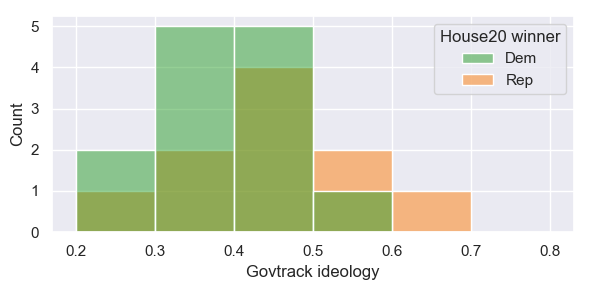

In [17]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
for_plot = dem_held_swing_districts[dem_held_swing_districts['House20 winner'] != 'Tie']
sns.histplot(
    data=for_plot, x='Govtrack ideology', 
    hue='House20 winner', bins=np.arange(0.2, 0.801, .1),
    palette={'Rep': 'tab:orange', 'Dem': 'tab:green'}
)
plt.tight_layout()

If this graph captured the whole story, then it would be clear evidence in favor of progressives' claims. It says that within swing districts, Democrats who lost (orange histogram) were more conservative than Democrats who won (green histogram). 

But of course, this graph doesn't capture the whole story! It's possible that more conservative Democrats were running in more conservative districts, where their races were tougher to begin with. In other words, we can't conclude from this information alone that being more conservative **caused** these Democrats to lose: the political climate within each district is a big confounding factor.

This motivates looking at what I'm calling the gains (i.e., the relative margin between previous elections and this one), which is what we'll do next.

### Comparing 2020 margin vs ideology score

In [18]:
def scatter_vs_ideology(y: str, dataset: pd.DataFrame = swing_districts, **plot_kwargs):
    """
    Draws a scatterplot comparing the specified column to
    govtrack ideology. Points are colored according to incumbent
    party, and marker style (• vs x) denotes who won in 2020.
    """
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

    # Draw x and y axes: y axis is at 0.5 (political center)
    ax.axvline(0.5, color='black', alpha=0.2)
    ax.plot([-1.03, 1.03], [0, 0], color='black', alpha=0.2, ls='--')

    ax_ylim = np.abs(dataset[y]).max() * 1.02
    sns.scatterplot(
        data=dataset, x='Govtrack ideology', y=y, 
        hue='Incumbent party', style='House20 winner',
        palette={'R': 'tab:red', 'D': 'tab:blue'}, alpha=0.7,
        **plot_kwargs
    )
    ax.legend(loc=2)
    ax.axis([-0.02, 1.02, -ax_ylim, ax_ylim])
    plt.tight_layout() 

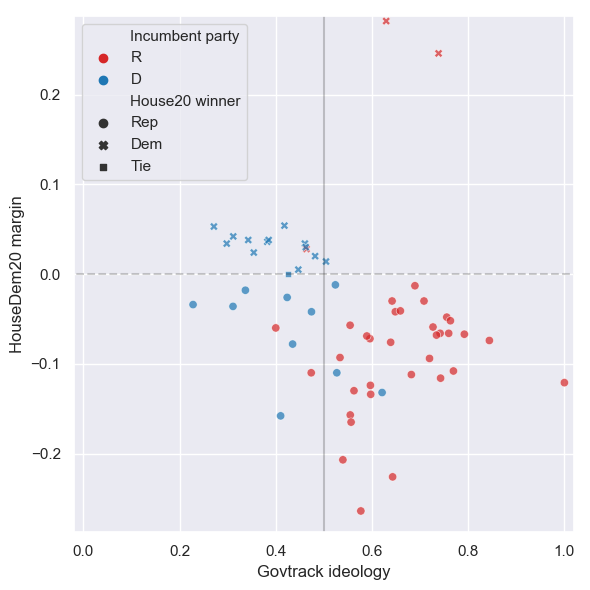

In [19]:
scatter_vs_ideology('HouseDem20 margin')

There's a negative correlation among districts with Democratic incumbents (blue points). In other words, Democratic candidates who are more conservative (higher govtrack ideology score) win by a smaller margin / lose by a bigger margin than more progressive ones (lower govtrack ideology score). This is consistent with what we saw above in the histogram. Just like before, we should be wary of the confounding factor of how liberal/conservative a particular district is.

Note that the negative correlation is true for each of the three large subgroups of districts:
* Districts with Democratic incumbents who won (points marked with a blue `x`)
* Districts with Democratic incumbents who lost (points marked with a blue `•`)
* Districts with Republican incumbents who won (points marked with a red `•`)

### Comparing gain over 2018 house election vs ideology score

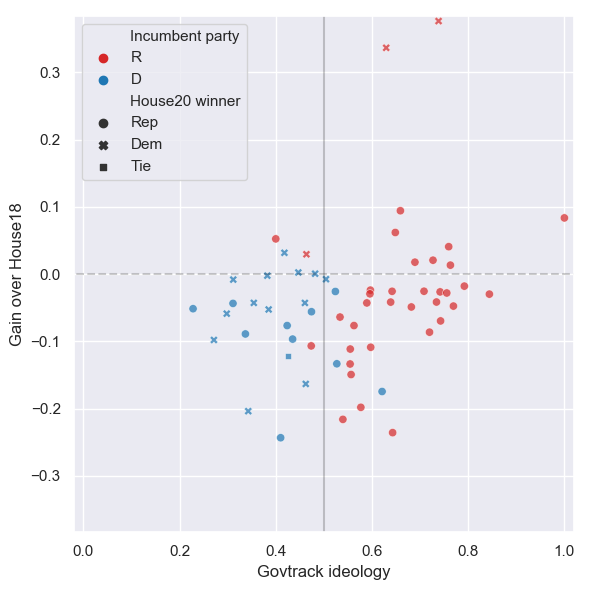

In [20]:
scatter_vs_ideology('Gain over House18')

I find this plot *fascinating*. A few things that jump out at me:

**Looking at the overall plot:**
* The "gains" are mostly negative. In other words, as has been widely reported on, Democrats tended to do worse in 2020 than in 2018.
* A few of the points are slightly misleading, since the incumbent chose not to run. These include Justin Amash (leftmost red point).

**Looking at the districts with Democratic incumbents (blue points):**
* There's a slight negative correlation: in other words, Democratic incumbents who were more conservative tended to underperform relative to 2018. 
  * The negative correlation looks more pronounced among districts where the Democratic incumbent lost (points marked with a blue `•`).
  * Specifically, it seems to be largely driven by the three most conservative incumbents (rightmost blue points). We'll investigate their districts a little more below.
* The most progressive incumbent (leftmost point) lost, and did about 5% worse than they did in 2018 (i.e., a "gain" of -5%). This looks pretty close to the average gain.

**Looking at the districts with Republican incumbents (red points):**
* Almost all of them won their races (i.e., there are a lot more red `•`s than red `x`s).
* Out of the three that flipped, two of them saw Dems doing *much* better than they did in 2018. We'll investigate them a little more below.
* There's a slight *positive* correlation: in other words, Republican incumbents who were more conservative tended to underperform relative to 2018 (their Democratic opponents overperformed).


### Comparing gain over 2012-2018 House average vs ideology score

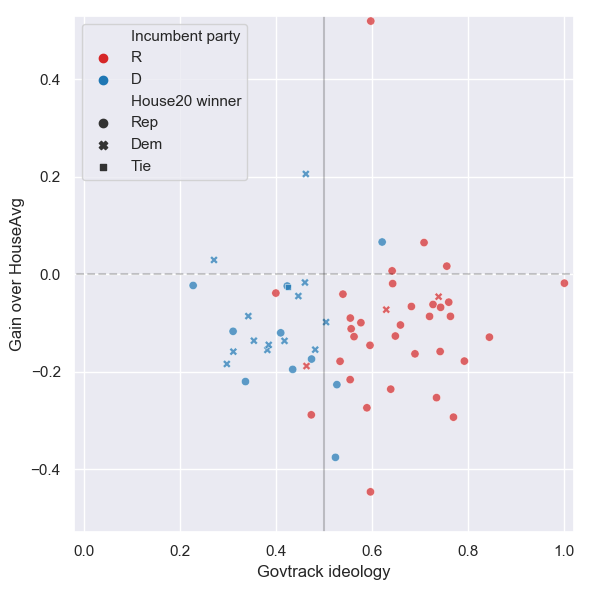

In [21]:
scatter_vs_ideology('Gain over HouseAvg')

The overall pattern looks similar to the previous graph. Most districts fall below the dotted horizontal line: in other words, the Democrats didn't just do worse than 2018; they did worse than they did over the last four elections (on average).

### Comparing gain over 2016 presidential election vs ideology score

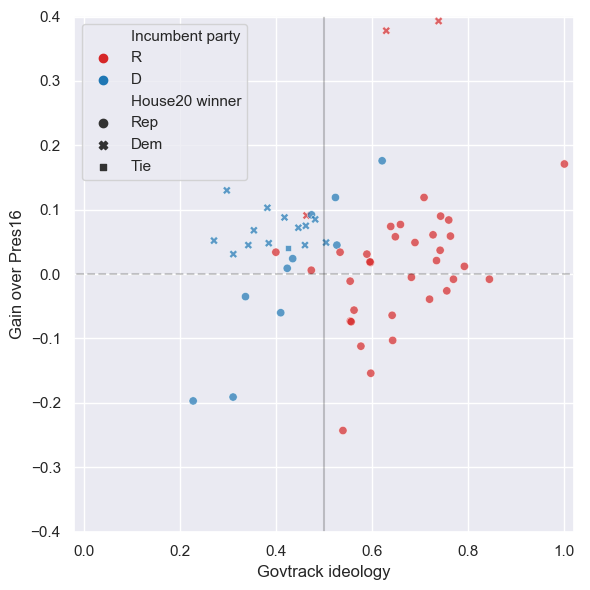

In [22]:
scatter_vs_ideology('Gain over Pres16')

This graph is interesting, too. Note that this a slightly different comparison from the last two graphs: Before, we were comparing 2020 House results to 2018 House results, or to 2012-2018 averaged House results. Now, we're comparing 2020 House results to 2016 presidential results.

**Looking at the districts with Democratic incumbents (blue points):**
* Overall, there's a *positive* correlation: in other words, Democratic incumbents who were more progressive tended to underperform relative to 2018. 
  * Among districts where the incumbent Democrat won (points marked with a blue `x`), this correlation seems to completely disappear: all of these districts have a moderate improvement over 2016, regardless of the incumbent's ideology
  * The correlation is driven entirely by the districts where the incumbent Democrat *lost*. In other words, among incumbent Democrats who lost (points marked with a blue `•`), the progressives (further left) did a lot worse relative to 2016 than the moderates (further right).
* The two biggest losers relative to 2016 (the two lowest blue `•`s) were also two of the most progressive. We'll investigate this a little more below.

**Looking at the districts with Republican incumbents (red points):**
* There's a *positive* correlation: in other words, Republican incumbents who were more conservative tended to underperform relative to 2016 (their Democratic opponents overperformed).

## Investigating individual districts

###  The three most conservative Democratic incumbents

In [23]:
dem_held_swing_districts.sort_values('Govtrack ideology').iloc[-3:, :]

,District,Trump16 margin,Obama12 margin,HouseDem18 margin,HouseDemAvg margin,RPT,HouseDem20 margin,House20 winner,Govtrack ideology,last_name,Gain over Pres16,Gain over House18,Gain over HouseAvg
341,SC-1,0.13,-1.81e-01,0.01,-0.36,1.00,-0.01,Rep,0.52,b'Cunningham',0.12,-0.03,-0.38
290,NY-22,0.15,-4.00e-03,0.02,-0.20,0.79,-0.11,Rep,0.53,b'Brindisi',0.04,-0.13,-0.23
216,MN-7,0.31,-9.80e-02,0.04,0.11,0.89,-0.13,Rep,0.62,b'Peterson',0.18,-0.17,0.07


Some facts about them:
* All three did better in 2020 than Hillary Clinton did in 2016
* All three did worse in 2020 than they did in 2018
* Brindisi (NY-22) and Peterson (MN-7) still have a lot of votes yet to be counted, as of my writing this

I also looked a little at their individual campaigns:

**Joe Cunningham (SC-1)** campaigned on a record of bipartisanship, [Republican support](https://www.youtube.com/watch?v=fvb6erwKYxY), and [COVID relief](https://www.youtube.com/watch?v=q-HSGHjlnms), but lost to a Republican who attacked him in debates for [being too close to Pelosi](https://www.usnews.com/news/best-states/south-carolina/articles/2020-10-06/cunningham-mace-hit-same-themes-at-sc-1st-district-debate). I found one of his opponent's ads that mentions support for "[Green New Deal taxes](https://www.youtube.com/watch?v=UvEpFsdXfcA)" despite [Cunningham's opposition to the plan](https://www.postandcourier.com/politics/sc-1st-congressional-district-cunningham-and-mace-differ-on-climate-change-science-views/article_52440c16-f439-11ea-a4c9-432b0c72caf4.html), but it seems like most of the attacks-by-association focused on Pelosi and Biden (rather than AOC or other progressives).

**Anthony Brindisi (NY-22)** also campaigned on [bipartisanship](https://www.youtube.com/watch?v=Gjqj8RSWn-M) and a record of [legislative accomplishment](https://www.uticaod.com/story/news/politics/elections/national/2020/10/27/ny-22-brindisi-tenney-meet-third-debate-election-day-looms/3745154001/). His opponent [tried to tie him to the movement to defund the police](https://www.youtube.com/watch?v=gaAbNA5Dm3M), but a local news story about their positions make it clear that Brindisi and his opponent [aren't very far apart on police reform](https://www.uticaod.com/story/news/politics/elections/national/2020/10/23/ny-22-brindisi-tenney-weigh-need-police-reform/3720984001/).

**Collin Peterson (MN-7)** ran on a 30-year record of bipartisanship in a district where Trump beat Clinton by 31 points. He [opposes Obamacare, supports abortion restrictions, and agrees with his opponent on many issues](https://www.grandforksherald.com/news/government-and-politics/6724871-Minnesota-7th-Collin-Peterson-faces-his-hardest-test-yet-in-Michelle-Fischbach). He was attacked for [Democrats' impeachment of Donald Trump, despite his own vote to oppose impeachment](https://www.sctimes.com/story/opinion/2019/11/27/attack-ads-rep-peterson-misleading/4310438002/).



###  The two biggest flips by Democrats

In [24]:
biggest_flips = swing_districts.sort_values('HouseDem20 margin', ascending=False)
biggest_flips.iloc[:2, :]

,District,Trump16 margin,Obama12 margin,HouseDem18 margin,HouseDemAvg margin,RPT,Incumbent party,HouseDem20 margin,House20 winner,Govtrack ideology,last_name,Gain over Pres16,Gain over House18,Gain over HouseAvg
232,NC-2,0.10,-0.13,-0.05,-0.13,0.98,R,0.28,Dem,0.63,b'Holding',0.38,0.34,-0.07
236,NC-6,0.15,-0.13,-0.13,-0.18,0.89,R,0.25,Dem,0.74,b'Walker',0.39,0.38,-0.05


North Carolina was [redistricted in 2019](https://www.washingtonpost.com/politics/2019/12/03/north-carolinas-new-congressional-map-shifts-two-seats-toward-democrats/) after a state court ruled its old map unconstitutionally partisan, and these two districts were expected to easily flip in favor of Democrats.

### The two most progressive losers (compared to Clinton in 2016)

In [25]:
dem_held_swing_districts.sort_values('Gain over Pres16').iloc[:2, :]

,District,Trump16 margin,Obama12 margin,HouseDem18 margin,HouseDemAvg margin,RPT,HouseDem20 margin,House20 winner,Govtrack ideology,last_name,Gain over Pres16,Gain over House18,Gain over HouseAvg
111,FL-26,-0.16,0.12,1.75e-02,-5.84e-03,0.95,-0.03,Rep,0.23,b'Mucarsel-Powell',-0.20,-0.05,-0.02
41,CA-21,-0.15,0.11,7.59e-03,-1.10e-01,0.83,-0.04,Rep,0.31,b'Cox',-0.19,-0.04,-0.12


These are both districts that Obama (in 2012) and Clinton (in 2016) solidly won, but Democrats just barely won in 2018. While the Republican in FL-26 has claimed victory, the CA-21 race is still in play.

**Debbie Mucarsel-Powell (FL-26)**, elected in 2018, ran on a [typical Democratic platform](https://www.debbiemucarselpowell.com/), supporting the [ACA over Medicare for All](https://floridianpress.com/2020/10/mucarsel-powell-supports-medicare-for-all-but-now-says-its-not-the-time-to-discuss-it/), and co-sponsoring the Green New Deal. Despite this, she appears to have been attacked primarily for [tenuous connections to Ukrainian oligarchs](https://www.miamiherald.com/news/politics-government/article214974800.html) rather than her political record. Mucarsel-Powell is an Ecuadorian immigrant, her opponent is a Cuban immigrant, and when she won the seat in 2018, she was "[the first person not from Cuba to represent the area in more than three decades](https://www.cnbc.com/2020/10/30/florida-house-race-debbie-mucarsel-powell-carlos-gimenez-in-tight-race.html)".

**TJ Cox (CA-21)** ran on [supporting working families](https://ballotpedia.org/California%27s_21st_Congressional_District_election,_2020), and attacked his opponent (who held the seat before 2018) for being a Trump loyalist. His opponent's attack ads focused on alleged [corruption](https://www.youtube.com/watch?v=6yB82icECIg) and [tax evasion](https://www.youtube.com/watch?v=XiTrnlJ0Bk8).

### The three most progressive winners

In [26]:
winners = dem_held_swing_districts[dem_held_swing_districts['House20 winner'] == 'Dem']
winners.sort_values('Govtrack ideology').iloc[:3, :]

,District,Trump16 margin,Obama12 margin,HouseDem18 margin,HouseDemAvg margin,RPT,HouseDem20 margin,House20 winner,Govtrack ideology,last_name,Gain over Pres16,Gain over House18,Gain over HouseAvg
319,OR-4,-1.00e-03,0.07,0.15,0.18,1.00,0.05,Dem,0.27,b'DeFazio',0.05,-9.80e-02,0.03
328,PA-8,9.60e-02,0.12,0.09,-0.09,0.93,0.03,Dem,0.30,b'Cartwright',0.13,-5.88e-02,-0.18
256,NJ-7,-1.10e-02,-0.06,0.05,-0.11,0.82,0.04,Dem,0.31,b'Malinowski',0.03,-8.19e-03,-0.16


Out of these three districts, Trump narrowly lost OR-4 and NJ-7 (by 0.1% and 1.1% respectively), and won PA-8 by a decisive margin (9.6%).

**Peter DeFazio (OR-4)** is a 34-year incumbent who has co-sponsored the [Green New Deal and Medicare for All](https://www.kgw.com/article/entertainment/television/programs/straight-talk/oregon-4th-district-congressional-race-defazio-skarlatos-preview/283-95b97974-285d-44c4-bcfd-be04811695b6). His opponent is a Republican famous for [stopping a terrorist attack on a Paris train](https://en.wikipedia.org/wiki/Alek_Skarlatos) with ties to the district's large timber industry. While his ads mention DeFazio's ["ties to socialism" and the Green New Deal's potential effect on the timber industry](https://twitter.com/alekskarlatos/status/1303437957345538048?lang=en), the focus is primarily on DeFazio's length tenure in Washington and how it puts him out of touch with Oregonians.

**Matt Cartwright (PA-8)** supports modified versions of progressive proposals, such as a [Green New Deal without a carbonless deadline](https://www.citizensvoice.com/news/election/cartwright-bognet-slug-it-out-in-debate-for-8th-congressional-district/article_7d84a083-891f-5529-a767-7aaded1f17bf.html) and [reallocating funding from police while expanding officer training](https://www.politifact.com/factchecks/2020/jul/09/jim-bognet/no-pa-congressman-matt-cartwright-did-not-call-def/). He [cosponsored Medicare for All](https://www.congress.gov/bill/116th-congress/house-bill/1384/cosponsors?searchResultViewType=expanded), but backed away from it somewhat during a debate. His opponent, a former Trump administration official, wants Pennsylvania to be the "[Saudi Arabia of the 21st century](https://www.pbssocal.org/programs/wvia-special-presentations/decision-2020-8th-congressional-district-debate-ultmsd/)". Many of his attacks focused on Cartwright voting "in lockstep with" Speaker Pelosi, Rep. Ocasio-Cortez, and Rep. Ilhan Omar.

**Tom Malinowski (NJ-7)** [ran on](https://newjerseyglobe.com/congress/malinowski-kean-disagree-on-health-care-campaign-finance-in-nj-7-debate/) defending the ACA (rather than Medicare for All), campaign finance reform, and COVID relief for small businesses. The only attack ads against him I could find used [a misleadingly edited audio clip and association with Pelosi](https://www.youtube.com/watch?v=hY4mn2cSSJU), [Malinowski's opposition to the Trump tax cuts](https://www.youtube.com/watch?v=ye3B8tI6l80), and [false accusations of helping sex offenders](https://www.washingtonpost.com/politics/2020/09/22/attack-ad-falsely-claims-lawmaker-helped-sexual-predators-hide-shadows/).

# Conclusions

As with any interpretation of data, this is necessarily subjective. I encourage you to use the data to draw your own conclusions, and also to acknowledge its limitations.

* Pelosi was a much more common antagonist in anti-Democratic attack ads than progressives like AOC or Ilhan Omar.
* Moderate Democratic incumbents in swing districts did much worse than 2018 (but still much better than Clinton in 2016). Their Republican opponents used a lot of attack ads tying them to Pelosi and Democratic progressives. These ties simply didn't exist, and many were closer ideologically to their Republican opponents than to someone like AOC.
* Progressive Democratic incumbents in swing districts did slightly worse than 2018, but tended to do either much better or much worse than Clinton in 2016. 
  * Among those who lost, most of the campaigning against them focused on issues not related to ideology: Mucarsel-Powell in FL-26 was attacked over her husband's employers, and Cox in CA-21 was attacked for alleged financial impropriety.
  * Among those who won, the attack ads seemed very similar in tone to the ones used against moderates. In other words, **in swing districts, moderates and progressives alike were attacked for their alleged ties to the far left, but those attacks didn't have as much of an effect on progressives**.
* Based on this data, it's hard for me to conclude that the Democratic party moved too far to the left. Swing progressives did better relative to 2018 than their swing moderate counterparts. A limited subjective analysis suggests that all swing Democrats were attacked for ties to the left, but progressives with actual ties to the left seemed to shrug those attacks off better than moderates.

Some other things that I learned along the way:

* It's surprisingly hard to find videos of individual campaign ads. Between SuperPACs, candidate YouTube channels full of news clips, and ads that seem to have disappeared, it took more sleuthing than I expected to find the ads. A probable consequence of this: my subjective analysis of the attack ads might be based on incomplete data.
* Election results data is sometimes openly available as a matter of public record (e.g., the [FEC](https://www.fec.gov/introduction-campaign-finance/election-and-voting-information/) and the [MIT Election Lab](https://electionlab.mit.edu/data), but conveniently formatted data is often stuck behind paywalls (e.g., [Dave Leip's Election Atlas](https://uselectionatlas.org/) and [Polidata](https://polidata.org/)).
* As with most exploratory data analysis, I learned a lot more from qualitative investigation of outliers and interesting data points than from the graphs.
* Local journalism matters a lot: most of my information about the candidates came from local outlets. This included debate summaries, fact checks on attack ads, important context about the district, and more.

# Future work

This notebook is necessarily an incomplete analysis. Here are some interesting future directions that came to mind as I was looking at this data.
* Predictive baseline: instead of using a previous election, or an average of the last few presidential elections as the baseline (as the PVI does), one could in theory build a predictive model of what to *expect* from this election and use that as the baseline. Some possibilities for the model:
  * Trend in House elections over time
  * Trend in House elections, but accounting for facts like "in the first midterm election after a new president takes office, the president's party usually does poorly"
  * Modeling fundamentals such as economic performance and incumbent strength (along the lines of what 538's election model does).
* Quantifying challengers' ideologies: the govtrack score is only available for incumbents, but challenger ideology could possibly 